In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

#print(tf.__version__)


2024-07-26 18:42:07.843966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hsibitenda/nltk_data...
[nltk_data]   Packag

In [2]:
# df=pd.read_csv('/home/hsibitenda/scratch/harriet/sentimentsall_sentences.csv')
# df=pd.read_csv('/home/hsibitenda/scratch/harriet/sentimentsall_sentences_aspects.csv')
# df=pd.read_csv('/home/hsibitenda/scratch/harriet/sentimentsall_sentences.csv')
# df=pd.read_csv('/home/hsibitenda/scratch/harriet/sentimentsall_sentences_aspects.csv')
df=pd.read_csv('/home/hsibitenda/scratch/harriet/sentiment_sentall_llama32.csv')
# df2=pd.read_csv('/home/hsibitenda/scratch/harriet/sentiments/social_analysis2.csv')
df2=pd.read_csv('/home/hsibitenda/scratch/harriet/sentiments/survey5.csv')
# df2=pd.read_csv('/home/hsibitenda/scratch/harriet/sentiments/survey2.csv')

# df7.to_csv('/home/hsibitenda/scratch/harriet/sentiments/sentiments_aspectsall_fine.csv')
df2=df2.astype(str)
df=df.astype(str)

In [3]:
# df.columns

In [30]:
merged_df.shape

(228, 63)

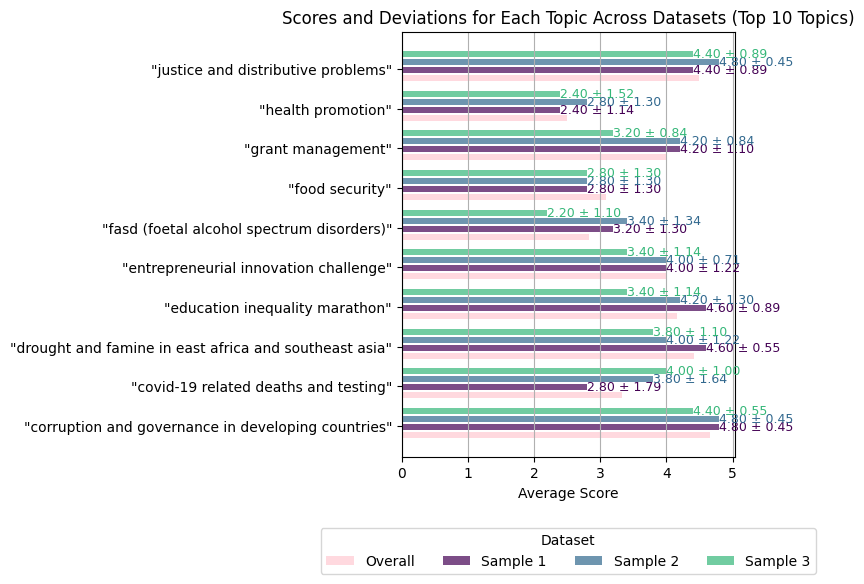

Overall Standard Deviation for Sample 1: 0.98
Overall Standard Deviation for Sample 2: 0.98
Overall Standard Deviation for Sample 3: 0.95


In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample function to select 5 participants randomly based on their email addresses
def sample_participants(df, seed):
    unique_emails = df['Participant email'].drop_duplicates()
    if len(unique_emails) < 5:
        raise ValueError("Not enough unique participants to sample 5.")
    sampled_emails = unique_emails.sample(n=5, replace=False, random_state=seed).tolist()
    return df[df['Participant email'].isin(sampled_emails)].copy()  # Ensure to work on a copy of the DataFrame

# Function to calculate the average, standard deviation, and count of scores for each topic
def calculate_topic_stats(df):
    topic_stats = df.groupby('Topic_Name')['Average_Topic_Score'].agg(['mean', 'std', 'count']).reset_index()
    topic_stats.columns = ['Topic_Name', 'Average_Score', 'Standard_Deviation', 'Count']
    return topic_stats

# Set the random seed for reproducibility
np.random.seed(42)

# Calculate topic statistics for the overall dataset
overall_topic_stats = calculate_topic_stats(df)

# List to store results for samples
sample_results = []

# Repeat sampling process three times with different seeds
seeds = [42, 43, 44]  # Different seeds for different samples

for seed in seeds:
    try:
        # Sample 5 participants
        sample_df = sample_participants(df, seed)
        
        # Calculate topic statistics for the sampled participants
        sample_topic_stats = calculate_topic_stats(sample_df)
        
        # Store results in the sample_results list
        sample_results.append(sample_topic_stats)
    except ValueError as e:
        print(e)
        break

# Combine overall and sample topic stats for plotting
plot_data = overall_topic_stats.copy()
plot_data['Source'] = 'Overall'

for i, sample_stats in enumerate(sample_results):
    sample_stats['Source'] = f'Sample {i + 1}'
    plot_data = pd.concat([plot_data, sample_stats])

# Limit to 10 topics
top_topics = plot_data['Topic_Name'].unique()[:10]
plot_data_filtered = plot_data[plot_data['Topic_Name'].isin(top_topics)]

# Define colors for the samples
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_results) + 1))

# Set up plotting
plt.figure(figsize=(8, 6))

# Define bar width and spacing
bar_width = 0.15
spacing = 0.05
y_positions = np.arange(len(top_topics))  # y positions for the topics

# Plotting the bars for overall data
plt.barh(y_positions - bar_width * (len(sample_results) / 2), 
         plot_data_filtered[plot_data_filtered['Source'] == 'Overall']['Average_Score'], 
         color='pink', alpha=0.6, label='Overall', height=bar_width)

# Plotting the bars for each sample
for i, source in enumerate([f'Sample {i + 1}' for i in range(len(sample_results))]):
    sample_data = plot_data_filtered[plot_data_filtered['Source'] == source]
    plt.barh(y_positions + (i + 1) * (bar_width + spacing) - bar_width * (len(sample_results) / 2), 
             sample_data['Average_Score'], 
             color=colors[i], alpha=0.7, label=source, height=bar_width)
    
    # Add annotations for average scores and standard deviations
    for j, topic in enumerate(sample_data['Topic_Name']):
        avg_score = sample_data['Average_Score'].iloc[j]
        std_dev = sample_data['Standard_Deviation'].iloc[j]
        plt.text(avg_score, y_positions[j] + (i + 1) * (bar_width + spacing) - bar_width * (len(sample_results) / 2), 
                 f'{avg_score:.2f} ± {std_dev:.2f}', 
                 va='center', ha='left', fontsize=9, color=colors[i])

# Customize plot
plt.yticks(y_positions, top_topics)
plt.xlabel('Average Score')
plt.title('Scores and Deviations for Each Topic Across Datasets (Top 10 Topics)')
plt.grid(axis='x')

# Add legend at the bottom
plt.legend(title='Dataset', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)

plt.tight_layout()
plt.show()

# Print overall standard deviations for each sample
for i, sample_stats in enumerate(sample_results):
    overall_std_dev = sample_stats['Standard_Deviation'].mean()
    print(f"Overall Standard Deviation for Sample {i + 1}: {overall_std_dev:.2f}")


In [517]:
df['Topic_Name'].unique()

array(['"health promotion"', '"entrepreneurial innovation challenge"',
       '"grant management"', '"justice and distributive problems"',
       '"mental health problem"',
       '"science exam questions and reactions"', '"food security"',
       '"refugee crisis"',
       '"nation building through sectoral fostering and intractable cohesion"',
       '"pandemic response"', '"covid-19 related deaths and testing"',
       '"urban-rural interface and environmental sustainability in sub-saharan africa"',
       '"corruption and governance in developing countries"',
       '"political leadership and overcoming obstacles"',
       '"youth empowerment and leadership in africa"',
       '"education inequality marathon"',
       '"drought and famine in east africa and southeast asia"',
       '"overcoming anxiety disorder"',
       '"fasd (foetal alcohol spectrum disorders)"'], dtype=object)

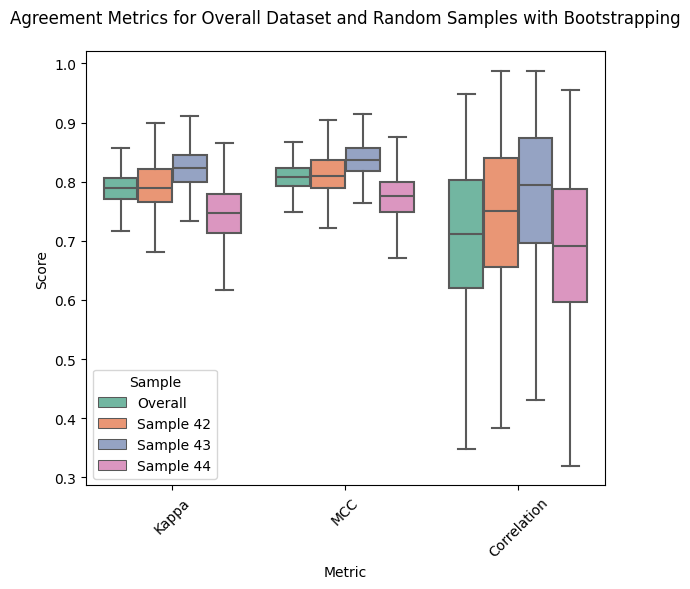

In [210]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Sample function to select 5 participants randomly based on their email addresses
def sample_participants(df, seed):
    unique_emails = df['Participant email'].drop_duplicates()
    if len(unique_emails) < 5:
        raise ValueError("Not enough unique participants to sample 5.")
    sampled_emails = unique_emails.sample(n=5, replace=False, random_state=seed).tolist()
    return df[df['Participant email'].isin(sampled_emails)].copy()  # Ensure to work on a copy of the DataFrame

# Function to generate Ground Truth Labels based on some criteria
def generate_ground_truth_labels(df):
    threshold = 2.5
    df['Ground_Truth_Label'] = np.where(df['Average_Topic_Score'] > threshold, df['Topic_Name'], 'no_topic')
    return df

# Function to encode text labels into numeric values
def encode_labels(df, column_name):
    df.loc[:, column_name + '_Num'] = pd.factorize(df[column_name])[0]
    return df

# Function to calculate Cohen’s Kappa, MCC, and Pearson Correlation for a given DataFrame
def calculate_agreement_metrics(df):
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(df['Ground_Truth_Label'], df['Topic_Name'])

    # Calculate MCC
    mcc = matthews_corrcoef(df['Ground_Truth_Label'], df['Topic_Name'])
    
    # Calculate Pearson Correlation Coefficient
    correlation = calculate_pearson_correlation(df)
    
    return kappa, mcc, correlation

# Function to calculate Pearson correlation with proper checks
def calculate_pearson_correlation(df):
    # Encode labels
    df = encode_labels(df, 'Ground_Truth_Label')
    df = encode_labels(df, 'Topic_Name')

    try:
        if len(df['Topic_Name_Num']) == len(df['Ground_Truth_Label_Num']):
            if len(np.unique(df['Topic_Name_Num'])) > 1 and len(np.unique(df['Ground_Truth_Label_Num'])) > 1:
                correlation, _ = pearsonr(df['Topic_Name_Num'], df['Ground_Truth_Label_Num'])
            else:
                correlation = np.nan  # Avoid constant input warning
        else:
            correlation = np.nan
    except ValueError:
        correlation = np.nan  # Handle cases where Pearson correlation cannot be computed

    return correlation

# Set the random seed for reproducibility
np.random.seed(42)

# Dictionary to store results
results = {'Overall': {'Kappa': np.nan, 'MCC': np.nan, 'Correlation': np.nan}}

# Generate ground truth labels
df = generate_ground_truth_labels(df)

# Calculate metrics for the entire dataset
try:
    overall_kappa, overall_mcc, overall_correlation = calculate_agreement_metrics(df)
    results['Overall']['Kappa'] = overall_kappa
    results['Overall']['MCC'] = overall_mcc
    results['Overall']['Correlation'] = overall_correlation
except Exception as e:
    print(f"Error calculating metrics for overall dataset: {e}")

# List to store results for samples and sampled DataFrames
sample_results = []
sample_dfs = []

# Repeat sampling process three times with different seeds
seeds = [42, 43, 44]  # Different seeds for different samples

for seed in seeds:
    try:
        # Sample 5 participants
        sample_df = sample_participants(df, seed)
        sample_dfs.append(sample_df)
        
        # Calculate metrics for the sampled participants
        sample_kappa, sample_mcc, sample_correlation = calculate_agreement_metrics(sample_df)
        
        # Store results in the sample_results list
        sample_results.append({
            'Sample': f'Sample {seed}',
            'Kappa': sample_kappa,
            'MCC': sample_mcc,
            'Correlation': sample_correlation
        })
    except ValueError as e:
        print(e)
        continue

# Perform bootstrap sampling
def bootstrap_sampling(df, n_iterations=1000, seed=42):
    np.random.seed(seed)
    bootstrap_metrics = []
    
    for i in range(n_iterations):
        bootstrap_sample = df.sample(n=len(df), replace=True)
        kappa, mcc, correlation = calculate_agreement_metrics(bootstrap_sample)
        bootstrap_metrics.append((kappa, mcc, correlation))
    
    return pd.DataFrame(bootstrap_metrics, columns=['Kappa', 'MCC', 'Correlation'])

# Bootstrap sampling for overall dataset
bootstrap_results_overall = bootstrap_sampling(df)

# Bootstrap sampling for each sample
bootstrap_results_samples = []
for seed, sample_df in zip(seeds, sample_dfs):
    bootstrap_sample_result = bootstrap_sampling(sample_df)
    bootstrap_sample_result['Sample'] = f'Sample {seed}'
    bootstrap_results_samples.append(bootstrap_sample_result)

# Combine all bootstrap results
all_bootstrap_results = pd.concat([bootstrap_results_overall.assign(Sample='Overall')] + bootstrap_results_samples)

# Melt the DataFrame for seaborn boxplot
all_bootstrap_results_melted = all_bootstrap_results.melt(id_vars=['Sample'], var_name='Metric', value_name='Value')

# Calculate the mean values for annotation
mean_values = all_bootstrap_results_melted.groupby(['Sample', 'Metric']).mean().reset_index()

# Plot boxplot
plt.figure(figsize=(6, 6))

# Draw the boxplot
ax = sns.boxplot(x='Metric', y='Value', hue='Sample', data=all_bootstrap_results_melted, palette='Set2', showfliers=False)

# Annotate each boxplot with mean values
for i in range(mean_values.shape[0]):
    row = mean_values.iloc[i]
    # Get the position of the boxes
    x = row['Metric']
    y = row['Value']
    sample = row['Sample']
    # Find the correct x-position for annotation f"{mean_value:.2f}\n({sample})"
    x_pos = list(mean_values['Metric'].unique()).index(x)
    # ax.text(x_pos, y + 0.05, f"{y:.2f}({ sample})", ha='center', va='bottom', fontsize=8, color='black', rotation=30)

plt.title('Agreement Metrics for Overall Dataset and Random Samples with Bootstrapping', pad=20)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()


Columns in all_bootstrap_results before melting: Index(['Sample', 'Metric', 'Metric_Value'], dtype='object')
Columns in combined_overall_results: Index(['Sample', 'Metric', 'Metric_Value'], dtype='object')
Columns in combined_samples_aggregated_melted: Index(['Sample', 'Metric', 'Metric_Value'], dtype='object')


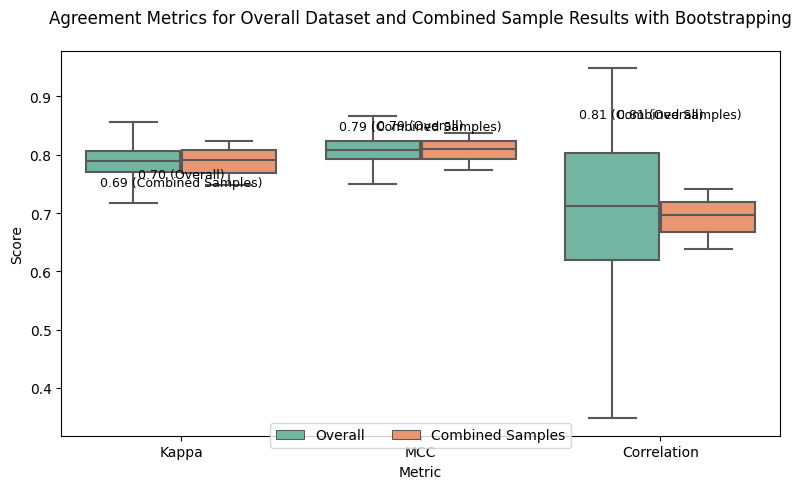

T-test results saved to 't_test_results_combined_samples.csv'.


In [337]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Sample function to select 5 participants randomly based on their email addresses
def sample_participants(df, seed):
    unique_emails = df['Participant email'].drop_duplicates()
    if len(unique_emails) < 5:
        raise ValueError("Not enough unique participants to sample 5.")
    sampled_emails = unique_emails.sample(n=5, replace=False, random_state=seed).tolist()
    return df[df['Participant email'].isin(sampled_emails)].copy()  # Ensure to work on a copy of the DataFrame

# Function to generate Ground Truth Labels based on some criteria
def generate_ground_truth_labels(df):
    threshold = 2.5
    df['Ground_Truth_Label'] = np.where(df['Average_Topic_Score'] > threshold, df['Topic_Name'], 'no_topic')
    return df

# Function to encode text labels into numeric values
def encode_labels(df, column_name):
    df.loc[:, column_name + '_Num'] = pd.factorize(df[column_name])[0]
    return df

# Function to calculate Cohen’s Kappa, MCC, and Pearson Correlation for a given DataFrame
def calculate_agreement_metrics(df):
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(df['Ground_Truth_Label'], df['Topic_Name'])

    # Calculate MCC
    mcc = matthews_corrcoef(df['Ground_Truth_Label'], df['Topic_Name'])
    
    # Calculate Pearson Correlation Coefficient
    correlation = calculate_pearson_correlation(df)
    
    return kappa, mcc, correlation

# Function to calculate Pearson correlation with proper checks
def calculate_pearson_correlation(df):
    # Encode labels
    df = encode_labels(df, 'Ground_Truth_Label')
    df = encode_labels(df, 'Topic_Name')

    try:
        if len(df['Topic_Name_Num']) == len(df['Ground_Truth_Label_Num']):
            if len(np.unique(df['Topic_Name_Num'])) > 1 and len(np.unique(df['Ground_Truth_Label_Num'])) > 1:
                correlation, _ = pearsonr(df['Topic_Name_Num'], df['Ground_Truth_Label_Num'])
            else:
                correlation = np.nan  # Avoid constant input warning
        else:
            correlation = np.nan
    except ValueError:
        correlation = np.nan  # Handle cases where Pearson correlation cannot be computed

    return correlation

# Set the random seed for reproducibility
np.random.seed(42)

# Generate ground truth labels
df = generate_ground_truth_labels(df)

# List to store results for samples and sampled DataFrames
sample_results = []
sample_dfs = []

# Repeat sampling process three times with different seeds
seeds = [42, 43, 44]  # Different seeds for different samples

for seed in seeds:
    try:
        # Sample 5 participants
        sample_df = sample_participants(df, seed)
        sample_dfs.append(sample_df)
        
        # Calculate metrics for the sampled participants
        sample_kappa, sample_mcc, sample_correlation = calculate_agreement_metrics(sample_df)
        
        # Store results in the sample_results list
        sample_results.append({
            'Sample': f'Sample {seed}',
            'Kappa': sample_kappa,
            'MCC': sample_mcc,
            'Correlation': sample_correlation
        })
    except ValueError as e:
        print(e)
        continue

# Perform bootstrap sampling
def bootstrap_sampling(df, n_iterations=1000, seed=42, replace=True):
    np.random.seed(seed)
    bootstrap_metrics = {'Kappa': [], 'MCC': [], 'Correlation': []}
    
    for _ in range(n_iterations):
        bootstrap_sample = df.sample(n=len(df), replace=replace)
        kappa, mcc, correlation = calculate_agreement_metrics(bootstrap_sample)
        bootstrap_metrics['Kappa'].append(kappa)
        bootstrap_metrics['MCC'].append(mcc)
        bootstrap_metrics['Correlation'].append(correlation)
    
    return pd.DataFrame(bootstrap_metrics)

# Bootstrap sampling for overall dataset (with replacement)
bootstrap_results_overall = bootstrap_sampling(df, replace=True)

# Bootstrap sampling for each sample (without replacement)
bootstrap_results_samples = []
for seed, sample_df in zip(seeds, sample_dfs):
    bootstrap_sample_result = bootstrap_sampling(sample_df, replace=False)
    bootstrap_sample_result['Sample'] = f'Sample {seed}'
    bootstrap_results_samples.append(bootstrap_sample_result)

# Create DataFrame for combined samples without replacement
combined_samples = pd.concat(bootstrap_results_samples)
combined_samples_aggregated = combined_samples.groupby('Sample').mean().reset_index()
combined_samples_aggregated['Sample'] = 'Combined Samples'

# Convert combined samples aggregated DataFrame to long format
combined_samples_aggregated_melted = combined_samples_aggregated.melt(id_vars=['Sample'], var_name='Metric', value_name='Metric_Value')

# Convert overall results to long format
combined_overall_results = pd.DataFrame({
    'Sample': ['Overall'] * len(bootstrap_results_overall),
    'Kappa': bootstrap_results_overall['Kappa'],
    'MCC': bootstrap_results_overall['MCC'],
    'Correlation': bootstrap_results_overall['Correlation']
}).melt(id_vars=['Sample'], var_name='Metric', value_name='Metric_Value')

# Combine all results for plotting
all_bootstrap_results = pd.concat([combined_overall_results, combined_samples_aggregated_melted])

# Inspect column names before melting
print("Columns in all_bootstrap_results before melting:", all_bootstrap_results.columns)
print("Columns in combined_overall_results:", combined_overall_results.columns)
print("Columns in combined_samples_aggregated_melted:", combined_samples_aggregated_melted.columns)

# Melt the DataFrame for seaborn boxplot
all_bootstrap_results_melted = all_bootstrap_results

# Calculate the mean values for annotation
mean_values = all_bootstrap_results_melted.groupby(['Sample', 'Metric']).mean().reset_index()

# Plot boxplot
plt.figure(figsize=(8, 5))

# Draw the boxplot
ax = sns.boxplot(x='Metric', y='Metric_Value', hue='Sample', data=all_bootstrap_results_melted, palette='Set2', showfliers=False)

# Annotate each boxplot with mean values
for i, row in mean_values.iterrows():
    x_pos = list(mean_values['Metric'].unique()).index(row['Metric'])
    ax.text(x_pos, row['Metric_Value'] + 0.05, f"{row['Metric_Value']:.2f} ({row['Sample']})", ha='center', va='bottom', fontsize=9, color='black', rotation=0)

# Add the legend at the bottom
plt.title('Agreement Metrics for Overall Dataset and Combined Sample Results with Bootstrapping', pad=20)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=0)  # Rotate x labels for better readability
plt.tight_layout()

# Move the legend to the bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.show()

# Statistical Testing: T-tests between the average of combined samples and the overall dataset
t_test_results = {'Sample': [], 'Metric': [], 'T-Statistic': [], 'P-Value': []}

for metric in ['Kappa', 'MCC', 'Correlation']:
    combined_samples_metric = combined_samples[metric]
    overall_data_metric = bootstrap_results_overall[metric]
    
    if len(combined_samples_metric) > 1 and len(overall_data_metric) > 1:
        stat, p_value = ttest_ind(combined_samples_metric, overall_data_metric)
        t_test_results['Sample'].append('Overall vs. Combined Samples')
        t_test_results['Metric'].append(metric)
        t_test_results['T-Statistic'].append(stat)
        t_test_results['P-Value'].append(p_value)
    else:
        t_test_results['Sample'].append('Overall vs. Combined Samples')
        t_test_results['Metric'].append(metric)
        t_test_results['T-Statistic'].append(np.nan)
        t_test_results['P-Value'].append(np.nan)

# Create DataFrame for t-test results
t_test_results_df = pd.DataFrame(t_test_results)

# Save the t-test results to a CSV file
t_test_results_df.to_csv('t_test_results_combined_samples.csv', index=False)

print("T-test results saved to 't_test_results_combined_samples.csv'.")


In [39]:
df=merged_df.copy()

In [120]:
df=merged_df.copy()
df['BERT-nlptown']=df[['BERT']]
df['finetunned_BERT']=df[['Sentiment2_prediction']]
df['finetunned_RoBERTa']=df[['Sentiment2_roberta']]
df['finetunned_Llama3']=df[['Predicted_Sentiment_finetunned']]
# Define the list of sentiment columns


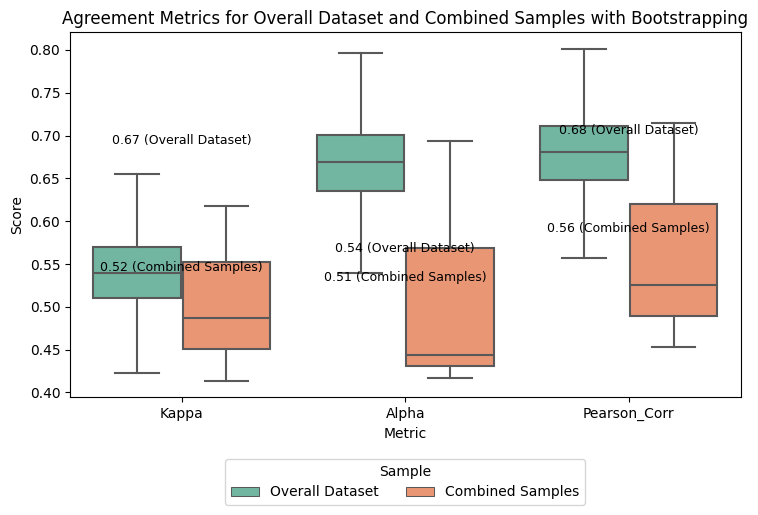

T-test results saved to 't_test_results.csv'.


In [344]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, ttest_ind
from sklearn.metrics import cohen_kappa_score
import krippendorff
import matplotlib.pyplot as plt
import seaborn as sns

# Example seed for reproducibility
seed = 42
np.random.seed(seed)

# Assuming df is your DataFrame
df = merged_df.copy()

# Convert Emotion_y to lowercase and remove any quotes
df['Emotion_y'] = df['Emotion_y'].str.lower().str.replace('"', '')

# Function to adjust emotions to only three labels
def adjust_emotions(emotion):
    if 'positive' in emotion:
        return 'positive'
    elif 'negative' in emotion:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the 'Emotion_y' column
df['Emotion_y'] = df['Emotion_y'].apply(adjust_emotions)

# Convert Emotion_y to numerical form for scoring
emotion_mapping = {'neutral': 0, 'positive': 1, 'negative': -1}
df['Emotion_Score'] = df['Emotion_y'].map(emotion_mapping)

# Function to create samples with different seeds
def create_samples(df, seeds, n_participants=5):
    samples = []
    for seed in seeds:
        np.random.seed(seed)
        participants = df['textid'].dropna().unique()
        sample_participants = np.random.choice(participants, size=n_participants, replace=False)
        sample_df = df[df['textid'].isin(sample_participants)]
        samples.append(sample_df)
    return samples

# Function to compute agreement metrics for a DataFrame
def compute_agreement_metrics(df):
    def get_mode(x):
        if not x.empty:
            mode_result = stats.mode(x, keepdims=False)
            if hasattr(mode_result.mode, '__iter__'):
                return mode_result.mode[0]
            else:
                return mode_result.mode
        return None
    
    mode_by_text = df.groupby('textid')['Emotion_Score'].apply(get_mode).reset_index()
    mode_by_text.rename(columns={'Emotion_Score': 'Mode_Score'}, inplace=True)
    
    df = pd.merge(df, mode_by_text, on='textid', how='left')
    df.dropna(subset=['Mode_Score'], inplace=True)
    
    if df.empty:
        return np.nan, np.nan, np.nan
    
    df['Ground_Truth_Numeric'] = df['Mode_Score']
    df['Emotion_Score_Numeric'] = df['Emotion_Score']
    
    emotion_scores = df['Emotion_Score_Numeric']
    ground_truth_scores = df['Ground_Truth_Numeric']
    
    kappa = cohen_kappa_score(emotion_scores, ground_truth_scores)
    alpha = krippendorff.alpha(reliability_data=[emotion_scores, ground_truth_scores], level_of_measurement='ordinal')
    
    if len(emotion_scores) > 1 and len(ground_truth_scores) > 1 and np.std(emotion_scores) > 0 and np.std(ground_truth_scores) > 0:
        pearson_corr, _ = pearsonr(emotion_scores, ground_truth_scores)
    else:
        pearson_corr = np.nan
    
    return kappa, alpha, pearson_corr

# Function for bootstrap sampling
def bootstrap_sampling(df, n_iterations=1000, seed=42, replace=True):
    np.random.seed(seed)
    bootstrap_metrics = {'Kappa': [], 'Alpha': [], 'Pearson_Corr': []}
    
    for _ in range(n_iterations):
        bootstrap_sample = df.sample(n=len(df), replace=replace)
        kappa, alpha, pearson_corr = compute_agreement_metrics(bootstrap_sample)
        bootstrap_metrics['Kappa'].append(kappa)
        bootstrap_metrics['Alpha'].append(alpha)
        bootstrap_metrics['Pearson_Corr'].append(pearson_corr)
    
    return pd.DataFrame(bootstrap_metrics)

# Define seeds for each sample
seeds = [42, 43, 44]

# Generate samples with different seeds
samples = create_samples(df, seeds)

# Collect metrics for each sample and the overall dataset
metrics = {'Sample': [], 'Metric': [], 'Value': []}

# Bootstrap sampling for the overall dataset
bootstrap_results_overall = bootstrap_sampling(df, replace=True)

# Add metrics for the overall dataset
metrics['Sample'].extend(['Overall Dataset'] * 3)
metrics['Metric'].extend(["Cohen's Kappa", "Krippendorff's Alpha", "Pearson's Correlation"])
metrics['Value'].extend([bootstrap_results_overall[metric].mean() for metric in ['Kappa', 'Alpha', 'Pearson_Corr']])

# Perform bootstrap sampling without replacement for each sample and calculate average metrics
combined_sample_results = {'Kappa': [], 'Alpha': [], 'Pearson_Corr': []}
for i, sample_df in enumerate(samples):
    bootstrap_results_sample = bootstrap_sampling(sample_df, replace=False)
    combined_sample_results['Kappa'].append(bootstrap_results_sample['Kappa'].mean())
    combined_sample_results['Alpha'].append(bootstrap_results_sample['Alpha'].mean())
    combined_sample_results['Pearson_Corr'].append(bootstrap_results_sample['Pearson_Corr'].mean())

# Calculate average metrics for combined samples
combined_sample_avg = {metric: np.mean(combined_sample_results[metric]) for metric in combined_sample_results}

# Add metrics for the combined sample results
metrics['Sample'].extend(['Combined Samples'] * 3)
metrics['Metric'].extend(["Cohen's Kappa", "Krippendorff's Alpha", "Pearson's Correlation"])
metrics['Value'].extend([combined_sample_avg[metric] for metric in ['Kappa', 'Alpha', 'Pearson_Corr']])

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Melt the DataFrame for seaborn boxplot
all_bootstrap_results_melted = pd.concat([
    bootstrap_results_overall.assign(Sample='Overall Dataset'),
    pd.DataFrame({metric: combined_sample_results[metric] for metric in combined_sample_results}).assign(Sample='Combined Samples')
])

# Melt the results for plotting
all_bootstrap_results_melted = all_bootstrap_results_melted.melt(id_vars=['Sample'], var_name='Metric', value_name='Value')

# Plot boxplot
plt.figure(figsize=(8, 5))

# Draw the boxplot
ax = sns.boxplot(x='Metric', y='Value', hue='Sample', data=all_bootstrap_results_melted, palette='Set2', showfliers=False)

# Calculate the mean values for annotation
mean_values = all_bootstrap_results_melted.groupby(['Sample', 'Metric']).mean().reset_index()

# Annotate each boxplot with mean values
for i, metric in enumerate(mean_values['Metric'].unique()):
    for j, sample in enumerate(mean_values['Sample'].unique()):
        row = mean_values[(mean_values['Metric'] == metric) & (mean_values['Sample'] == sample)]
        if not row.empty:
            y = row['Value'].values[0]
            x_pos = i + j * 0
            ax.text(x_pos, y + 0.02, f"{y:.2f} ({sample})", ha='center', va='bottom', fontsize=9, color='black', rotation=0)

# Add title and labels
plt.title("Agreement Metrics for Overall Dataset and Combined Samples with Bootstrapping")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.xticks(rotation=0)  # Rotate x labels for better readability
plt.tight_layout(pad=2.5)  # Adjust padding to prevent overlap

# Add the legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, title='Sample')

# Save the plot
plt.savefig('agreement_metrics_plot.png', bbox_inches='tight')

# Show the plot
plt.show()

# Statistical Testing: T-tests between the average of all samples and the overall dataset
t_test_results = {'Sample': [], 'Metric': [], 'T-Statistic': [], 'P-Value': []}

for metric in ['Kappa', 'Alpha', 'Pearson_Corr']:
    sample_averages = pd.Series(combined_sample_results[metric]).dropna()
    overall_data = bootstrap_results_overall[metric].dropna()
    
    if len(sample_averages) > 1 and len(overall_data) > 1:
        stat, p_value = ttest_ind(sample_averages, overall_data)
        t_test_results['Sample'].append('Overall vs. Combined Samples')
        t_test_results['Metric'].append(metric)
        t_test_results['T-Statistic'].append(stat)
        t_test_results['P-Value'].append(p_value)
    else:
        t_test_results['Sample'].append('Overall vs. Combined Samples')
        t_test_results['Metric'].append(metric)
        t_test_results['T-Statistic'].append(np.nan)
        t_test_results['P-Value'].append(np.nan)

# Create DataFrame for t-test results
t_test_results_df = pd.DataFrame(t_test_results)

# Save the t-test results to a CSV file
t_test_results_df.to_csv('t_test_results.csv', index=False)

print("T-test results saved to 't_test_results.csv'.")


In [345]:
t_test_results_df

,Sample,Metric,T-Statistic,P-Value
0,Overall vs. Combined Samples,Kappa,-1.363855,1.729198e-01
1,Overall vs. Combined Samples,Alpha,-5.182376,2.649270e-07
2,Overall vs. Combined Samples,Pearson_Corr,-4.149621,3.613308e-05


In [346]:
mean_values

,Sample,Metric,Value
0,Combined Samples,Alpha,0.518132
1,Combined Samples,Kappa,0.506107
2,Combined Samples,Pearson_Corr,0.564340
3,Overall Dataset,Alpha,0.666807
4,Overall Dataset,Kappa,0.540698
5,Overall Dataset,Pearson_Corr,0.678450


In [316]:
metrics_df

,Sample,Metric,Value
0,Overall Dataset,Cohen's Kappa,0.540698
1,Overall Dataset,Krippendorff's Alpha,0.666807
2,Overall Dataset,Pearson's Correlation,0.678450
3,Combined Samples,Cohen's Kappa,0.506107
4,Combined Samples,Krippendorff's Alpha,0.518132
5,Combined Samples,Pearson's Correlation,0.564340


In [50]:
df=merged_df.copy()

In [39]:
df['Theme'].unique()

array(['security', 'security, health, education',
       'poverty, health, education', 'health, education', 'health',
       'others', 'employment', 'education', 'poverty, employment',
       'employment, education', 'poverty, employment, education',
       'poverty', 'security, others',
       'poverty, hunger, security, health, employment, education',
       'employment, education, others', 'health, education, others',
       'education, others', 'hunger, health', 'poverty, hunger, health',
       'hunger, security, health', 'hunger, employment',
       'security, employment', 'poverty, security',
       'poverty, hunger, security, employment',
       'poverty, hunger, security',
       'security, employment, education, others', 'security, health',
       'health, employment', 'security, health, employment',
       'health, others', 'poverty, health, employment, education, others',
       'hunger, security, education', 'employment, others',
       'security, employment, education', '

Sample size adjusted to 228 because it's larger than the dataset.
Sample 1 DataFrame Head:
  Unnamed: 0 textid                       Date Views sourcetype  \
0      17228   4711  2021-11-27 03:30:45+00:00     0    twitter   
1       9005   8784  2022-08-18 11:29:59+00:00     2    twitter   
2       1009   6332  2021-02-11 06:06:07+00:00     2    twitter   
3      15022   7499  2022-06-03 02:20:39+00:00     0    twitter   
4      15719   1098  2019-12-05 09:17:32+00:00     5    twitter   

                                             alltext  \
0  markets sold off worldwide on friday after sou...   
1  @dsengeh good morning sir; how was your night ...   
2  he is interested in the intersection of educat...   
3  andy vermaut shares:water scarcity and drought...   
4  #impactafrica19 is a partnership by the britis...   

                                            Text_emt  \
0  markets sold off worldwide on friday after sou...   
1  @dsengeh good morning sir; how was your night ...   
2

/tmp/ipykernel_1691772/2209689938.py:183: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(sample_values, full_values, equal_var=False)


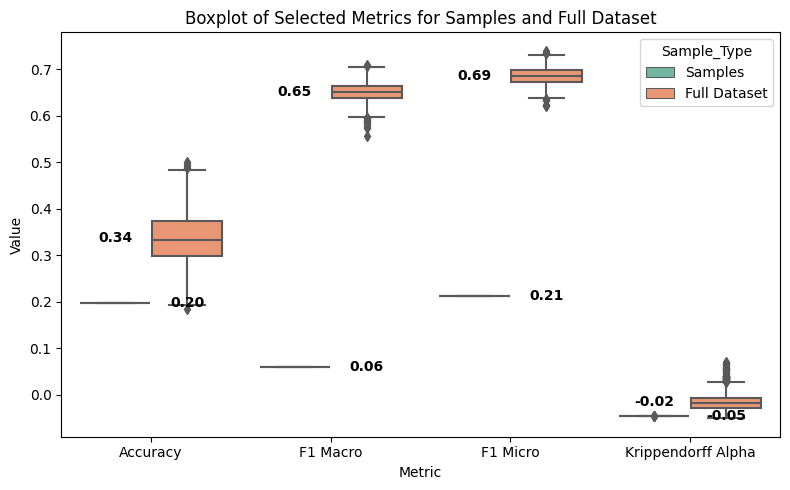

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
import krippendorff
from scipy import stats

# Assuming merged_df is already defined and loaded
df = merged_df.copy()

# Clean the 'Theme' column: remove quotes and convert to lowercase
df['Theme'] = df['Theme'].str.replace('"', '').str.lower()

# Define the numerical mapping for themes
theme_mapping = {
    'others': 0,
    'poverty': 1,
    'hunger': 2,
    'health': 3,
    'employment': 4,
    'education': 5,
    'security': 6
}

# Reverse mapping for themes
reverse_theme_mapping = {v: k for k, v in theme_mapping.items()}

# Map 'Theme' to 'Theme_Mapped'
df['Theme_Mapped'] = df['Theme'].apply(lambda x: [theme_mapping.get(theme.strip(), 0) for theme in x.split(',')])

# Define a function to calculate agreement metrics
def calculate_agreement_metrics(df):
    df = df.dropna(subset=['Theme_Mapped', 'Final_Label'])
    if df.empty:
        return np.nan, np.nan, np.nan, np.nan

    # Flatten the list of themes
    df['Final_Label_List'] = df['Final_Label'].apply(lambda x: [int(i) for i in x.split(',') if i.isdigit()])

    # Use MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=list(theme_mapping.values()))

    y_true = mlb.fit_transform(df['Theme_Mapped'])
    y_pred = mlb.transform(df['Final_Label_List'])

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    # Transpose y_true and y_pred for Krippendorff's Alpha calculation
    reliability_data = np.vstack([y_true.T, y_pred.T])
    alpha = krippendorff.alpha(reliability_data=reliability_data)

    return accuracy, f1_macro, f1_micro, alpha

def compute_final_labels(df):
    """Compute final labels based on the majority theme."""
    topic_common_themes = df.groupby('Topic_Name')['Theme_Mapped'].apply(lambda x: ','.join(map(str, sum(x, [])))).reset_index()
    topic_participant_count = df.groupby('Topic_Name')['Participant email'].nunique().reset_index()
    topic_participant_count.rename(columns={'Participant email': 'Participant_Count'}, inplace=True)
    topic_common_themes = pd.merge(topic_common_themes, topic_participant_count, on='Topic_Name', how='left')

    def calculate_final_label(row):
        themes = pd.Series(row['Theme_Mapped'].split(','))
        theme_counts = themes.value_counts()
        half_participants = row['Participant_Count'] / 2
        common_themes = theme_counts[theme_counts >= half_participants].index
        return ','.join(common_themes) if len(common_themes) > 0 else '0'

    topic_common_themes['Final_Label'] = topic_common_themes.apply(calculate_final_label, axis=1)
    df = pd.merge(df, topic_common_themes[['Topic_Name', 'Final_Label']], on='Topic_Name', how='left')

    # Handle 'NaN' and 'float' values in 'Final_Label'
    if 'Final_Label' not in df.columns:
        df['Final_Label'] = np.nan

    df['Final_Label'] = df['Final_Label'].fillna('0')

    def map_final_label(x):
        if pd.isna(x) or x == '0':
            return 'Unknown'
        return ','.join([reverse_theme_mapping.get(int(val), 'Unknown') for val in x.split(',')])
    
    df['Final_Label_Themes'] = df['Final_Label'].apply(map_final_label)
    
    return df

def sample_data(df, seed, sample_size=1000):
    """Generate a sample of the dataset."""
    np.random.seed(seed)
    
    # Ensure sample size does not exceed the number of available rows
    if sample_size > len(df):
        sample_size = len(df)
        print(f"Sample size adjusted to {sample_size} because it's larger than the dataset.")

    return df.sample(n=sample_size, random_state=seed, replace=False)

def perform_bootstrapping_and_calculate_metrics(df, n_bootstraps, with_replacement=True):
    metrics = []
    data_length = len(df)
    for _ in range(n_bootstraps):
        if with_replacement:
            bootstrapped_df = df.sample(frac=1, replace=True, random_state=np.random.randint(1, 10000))
        else:
            bootstrapped_df = df.sample(n=min(data_length, 1000), replace=False, random_state=np.random.randint(1, 10000))
        bootstrapped_df = compute_final_labels(bootstrapped_df)
        if 'Final_Label' in bootstrapped_df.columns:
            metrics.append(calculate_agreement_metrics(bootstrapped_df))
    if metrics:
        avg_metrics = np.mean(metrics, axis=0)
        return avg_metrics, metrics
    else:
        return (np.nan, np.nan, np.nan, np.nan), []

# Define the number of bootstraps and the number of samples
n_bootstraps = 1000
num_samples = 3

# Initialize lists to store metrics
all_sample_metrics = []
metrics_all_samples = []

# Create and process each sample
for sample_index in range(num_samples):
    sample_df = sample_data(df, seed=sample_index + 42)  # Adjust the seed and sample size as needed
    sample_df = compute_final_labels(sample_df)
    
    # Print the head of the sample DataFrame
    print(f"Sample {sample_index + 1} DataFrame Head:")
    print(sample_df.head())
    
    try:
        avg_metrics, metrics = perform_bootstrapping_and_calculate_metrics(sample_df, n_bootstraps, with_replacement=False)
        all_sample_metrics.append(avg_metrics)
        metrics_all_samples.extend(metrics)  # Collect all metrics for boxplot
        
        # Print results for each sample
        print(f'Sample {sample_index + 1} - Average Metrics:')
        print(f'  Accuracy: {avg_metrics[0]}')
        print(f'  F1 Macro: {avg_metrics[1]}')
        print(f'  F1 Micro: {avg_metrics[2]}')
        print(f'  Krippendorff Alpha: {avg_metrics[3]}')
    except ValueError as e:
        print(f"Error processing Sample {sample_index + 1}: {e}")

# Calculate metrics for the entire dataset with replacement
try:
    avg_metrics_full, metrics_full = perform_bootstrapping_and_calculate_metrics(df, n_bootstraps, with_replacement=True)
    print('Entire Dataset - Average Metrics:')
    print(f'  Accuracy: {avg_metrics_full[0]}')
    print(f'  F1 Macro: {avg_metrics_full[1]}')
    print(f'  F1 Micro: {avg_metrics_full[2]}')
    print(f'  Krippendorff Alpha: {avg_metrics_full[3]}')
except ValueError as e:
    print(f"Error processing the entire dataset: {e}")

# Combine metrics from all samples and calculate the mean for each metric
all_sample_metrics = np.array(all_sample_metrics)
mean_sample_metrics = np.mean(all_sample_metrics, axis=0)

# Prepare data for boxplot
metrics_sample_df = pd.DataFrame(metrics_all_samples, columns=['Accuracy', 'F1 Macro', 'F1 Micro', 'Krippendorff Alpha'])
metrics_sample_df['Sample_Type'] = 'Samples'

metrics_full_df = pd.DataFrame(metrics_full, columns=['Accuracy', 'F1 Macro', 'F1 Micro', 'Krippendorff Alpha'])
metrics_full_df['Sample_Type'] = 'Full Dataset'

# Combine metrics from samples and full dataset
combined_metrics_df = pd.concat([metrics_sample_df, metrics_full_df], ignore_index=True)

# Melt the DataFrame for plotting
melted_results = pd.melt(combined_metrics_df, id_vars=['Sample_Type'], var_name='Metric', value_name='Value')

# Perform t-tests
t_test_results = {}
for metric in ['Accuracy', 'F1 Macro', 'F1 Micro', 'Krippendorff Alpha']:
    sample_values = metrics_sample_df[metric].values
    full_values = metrics_full_df[metric].values
    t_stat, p_val = stats.ttest_ind(sample_values, full_values, equal_var=False)
    t_test_results[metric] = {'t-statistic': t_stat, 'p-value': p_val}

# Print t-test results
print("\nT-Test Results:")
for metric, result in t_test_results.items():
    print(f"{metric}: t-statistic = {result['t-statistic']:.3f}, p-value = {result['p-value']:.3f}")

# Create a single boxplot for each metric
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x='Metric', y='Value', hue='Sample_Type', data=melted_results, palette='Set2')
plt.title('Boxplot of Selected Metrics for Samples and Full Dataset')

# Annotate with metric scores and dataset names
for i, metric in enumerate(melted_results['Metric'].unique()):
    metric_data = melted_results[melted_results['Metric'] == metric]
    for j, sample_type in enumerate(metric_data['Sample_Type'].unique()):
        sample_data = metric_data[metric_data['Sample_Type'] == sample_type]['Value']
        mean_value = sample_data.mean()
        ax.text(i + (0.2 if sample_type == 'Samples' else -0.2), mean_value, f'{mean_value:.2f}', 
                horizontalalignment='center', 
                verticalalignment='center', 
                fontsize=10, 
                weight='bold')

plt.tight_layout()
plt.show()

